In [1]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L

In [2]:
def psi(g,e):
    return np.array([g, e])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    result = psi(0.0+0.0j,0.0+0.0j)
    for n in range(Ncut):
        result += prob(n,nbar)*pulse(t, Omega0*Omega(n,0,eta), delPrime, 0.0, 0.0)@psi0
    return result

def therm3DPulse(psi0, t, Omega0, delPrime, nbars, Omegas, Ncut):
    nbarx = nbars[0]
    nbary = nbars[1]
    nbarz = nbars[2]
    #Ncut = 100
    result = psi(0.0+0.0j,0.0+0.0j)
    for nx in range(Ncut):
        Probx = prob(nx,nbarx)
        for ny in range(Ncut):
            Probxy = Probx*prob(ny,nbary)
            for nz in range(Ncut):
                result += Probxy*prob(nz,nbarz)*pulse(t, Omega0*Omegas[nx,ny,nz], delPrime, 0.0, 0.0)@psi0
    return result

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2)              #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

In [3]:
def HRerrSig(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02):
    pulse1 = pulse(t1, Omega01, delPrime, 0.0, 0.0)
    pulse2 = pulse(t2, Omega02, delPrime, 0.0, 0.0)
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    
    return rhoee(pulse2@freeEvo@pi2PhaseInjP@pulse1@psi0) - rhoee(pulse2@freeEvo@pi2PhaseInjM@pulse1@psi0)

$\delta_d = $ dark time detuning and $\Delta$ = light shift estimate error (LSEE)

In [4]:
def HRJumperrSig(deld, psi0, t1, T, t2, Delta, Omega01, Omega02, Omega03):
    delPrime = deld - Delta
    pulse1 = pulse(t1, Omega01, delPrime, 0.0, 0.0)
    pulse2 = pulse(2.0*t2/3.0, -Omega02, delPrime, 0.0, 0.0)
    pulse3 = pulse(t2/3.0, Omega03, delPrime, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    return rhoee(pulse3@pulse2@pi2PhaseInjP@freeEvo@pulse1@psi0) - rhoee(pulse3@pulse2@pi2PhaseInjM@freeEvo@pulse1@psi0)

def HRJumpThermErrSig3D(deld, psi0, t1, T, t2, Delta, Omega0s, nbars, Omegas, Ncut):
    Omega01 = Omegas[0]
    Omega02 = Omegas[1]
    Omega03 = Omegas[2]
    nbarx = nbars[0]
    nbary = nbars[1]
    nbarz = nbars[2]
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    intState = freeEvo@therm3DPulse(psi0, t1, Omega01, delPrime, nbars, Omegas, Ncut)
    resultP = therm3DPulse(therm3DPulse(pi2PhaseInjP@intState, 2.0*t2/3.0, -Omega02, delPrime, nbars, Omegas, Ncut), t2/3.0, Omega03, delPrime, nbars, Omegas, Ncut)
    resultM = therm3DPulse(therm3DPulse(pi2PhaseInjM@intState, 2.0*t2/3.0, -Omega02, delPrime, nbars, Omegas, Ncut), t2/3.0, Omega03, delPrime, nbars, Omegas, Ncut)
    return rhoee(resultP) - rhoee(resultM)

def HRJumpThermErrSig(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    #nbar = nbar0 + nbardot*T
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    #def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    intState = thermPulse(psi0, t1, Omega0, delPrime, eta, nbar0, Ncut)
    resultP = thermPulse(thermPulse(freeEvo@pi2PhaseInjP@intState, 2.0*t2/3.0, -Omega0, delPrime, eta, nbarf, Ncut), t2/3.0, Omega0, delPrime, eta, nbarf, Ncut)
    resultM = thermPulse(thermPulse(freeEvo@pi2PhaseInjM@intState, 2.0*t2/3.0, -Omega0, delPrime, eta, nbarf, Ncut), t2/3.0, Omega0, delPrime, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

def RamseyErrSig(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    #nbar = nbar0 + nbardot*T
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    intState = thermPulse(psi0, t1, Omega0, delPrime, eta, nbar0, Ncut)
    resultP = thermPulse(freeEvo@pi2PhaseInjP@intState, t2, Omega0, delPrime, eta, nbarf, Ncut)
    resultM = thermPulse(freeEvo@pi2PhaseInjM@intState, t2, Omega0, delPrime, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

In [5]:
pts = 15
Ncuts = np.array([701, 801, 901])
psi0 = psi(0.0, 1.0)
Delta = 1.0 #*(2.0*np.pi) #hz
Omega0 = 50.0 #*(2.0*np.pi) #hz
nbar0 = 10.0 
t1 = np.pi/(2.0*Omega0)
T = 20.0/Omega0
#t2 = 3.0*np.pi/(2.0*Omega0)
eta = 0.05
nbarfs = np.linspace(10, 150, pts)
shifts1 = np.zeros([np.size(Ncuts), pts])
shifts2 = np.zeros(pts)
tol = 1.0e-11
guessTol = 5.0
for ii in range(np.size(Ncuts)):
    print(Ncuts[ii])
    x0 = -0.1
    x1 = 0.5
    for jj in range(pts):
        print(nbarfs[jj])
        shifts1[ii][jj] = sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, 3.0*np.pi/(2.0*Omega0), Delta, Omega0, eta, nbar0, nbarfs[jj], Ncuts[ii]), bracket=[x0,x1], xtol = tol).root
        #print(shifts1[ii])
        x0 = shifts1[ii][jj] - guessTol
        x1 = shifts1[ii][jj]
        #print(x0,x1)

701
10.0


D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:651: RuntimeWarning: invalid value encountered in double_scalars
  hn = _gam(n + alpha + 1) / _gam(n + 1)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:140: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: overflow encountered in true_divide
  w = 1.0 / (fm * dy)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:202: RuntimeWarning: invalid value encountered in multiply
  w *= mu0 / w.sum()
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:127: RuntimeWarning: invalid value encountered in double_scalars
  equiv_weights = [weights[k] / wfunc(roots[k]) for
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / (fm * dy)
D:\Mark\Python\lib\site-packages\scipy\special\_or

20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
801
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
901
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0


In [7]:
pts = 15
Ncuts = np.array([801])
psi0 = psi(0.0, 1.0)
Delta = 1.0 #*(2.0*np.pi) #hz
Omega0 = 50.0 #*(2.0*np.pi) #hz
nbar0 = 10.0 
t1 = np.pi/(2.0*Omega0)
T = 20.0/Omega0
#t2 = 3.0*np.pi/(2.0*Omega0)
eta = 0.05
nbarfs = np.linspace(10, 150, pts)
shifts2 = np.zeros([np.size(Ncuts), pts])
tol = 1.0e-11
guessTol = 5.0
for ii in range(np.size(Ncuts)):
    print(Ncuts[ii])
    x0 = -0.1
    x1 = 0.5
    for jj in range(pts):
        print(nbarfs[jj])
        shifts2[ii][jj] = sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, 3.0*np.pi/(2.0*Omega0), Delta, Omega0, eta, nbar0, nbarfs[jj], Ncuts[ii]), bracket=[x0,x1], xtol = tol).root
        #print(shifts1[ii])
        x0 = shifts2[ii][jj] - guessTol
        x1 = shifts2[ii][jj]
        #print(x0,x1)

201
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
401
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
601
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0


In [146]:
tol = 1.0e-11
x0 = -3.0
x1 = 0.1
guessTol = 5.0
pt2s = 15
nbarf2s = np.linspace(10, 150, pt2s)
shifts2 = np.zeros(pt2s)

for ii in range(pt2s):
    #print(ii)
    #print(nbarf2s[ii])
    shifts2[ii] = sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, 7.0*np.pi/(2.0*Omega0), Delta, Omega0, eta, nbar0, nbarf2s[ii], Ncut), bracket=[x0,x1], xtol = tol).root
    #print(shifts2[ii])
    x0 = shifts2[ii]  - guessTol
    x1 = shifts2[ii]  #+ guessTol/10.0
    #print(x0,x1)

Comparing $3\pi/2$ Ramsey style pulse sequence to $7\pi/2$ to see if they are similar.

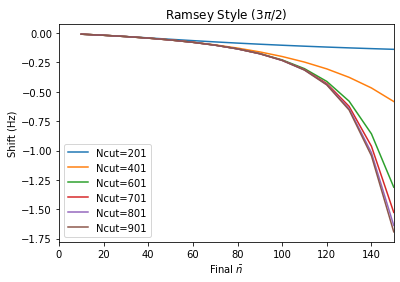

In [11]:
plt.plot(nbarfs,shifts2[0,:], label="Ncut=201")
plt.plot(nbarfs,shifts2[1,:], label="Ncut=401")
plt.plot(nbarfs,shifts2[2,:], label='Ncut=601')
plt.plot(nbarfs,shifts1[0,:], label="Ncut=701")
plt.plot(nbarfs,shifts1[1,:], label="Ncut=801")
plt.plot(nbarfs,shifts1[2,:], label='Ncut=901')
plt.title(r"Ramsey Style ($3\pi/2$)")
plt.xlabel(r'Final $\bar{n}$')
plt.ylabel("Shift (Hz)")
plt.legend()
plt.xlim([0,150])
#plt.ylim([-0.5,0])
plt.show()

Text(0, 0.5, 'Error (%)')

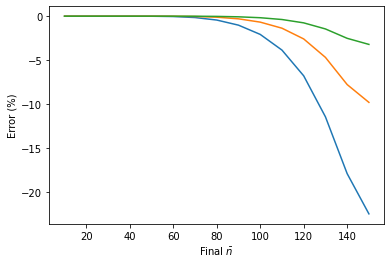

In [17]:
err1 = (shifts2[2,:] - shifts1[2,:])/shifts1[2,:]*100.0
err2 = (shifts1[0,:] - shifts1[2,:])/shifts1[2,:]*100.0
err3 = (shifts1[1,:] - shifts1[2,:])/shifts1[2,:]*100.0
plt.plot(nbarfs, err1) #Ncut = 601
plt.plot(nbarfs, err2) #Ncut = 701
plt.plot(nbarfs, err3) #Ncut = 801


plt.xlabel(r'Final $\bar{n}$')
plt.ylabel("Error (%)")

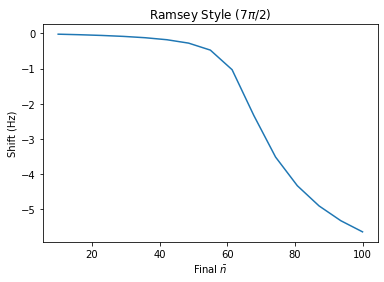

In [147]:
plt.plot(nbarf2s,shifts2)
plt.title(r"Ramsey Style ($7\pi/2$)")
plt.xlabel(r'Final $\bar{n}$')
plt.ylabel("Shift (Hz)")
plt.show()

In [148]:
pts = 40
Ncut = 201
psi0 = psi(0.0, 1.0)
Deltas = np.linspace(-20.0, 20.0, pts) #hz
Omega0 = 50.0 #*(2.0*np.pi) #hz
t1 = np.pi/(2.0*Omega0)
T = 20.0/Omega0
t2 = 3.0*np.pi/(2.0*Omega0)
eta = 0.05
nbar0 = 10.0
nbarf = 20.0
shifts = np.zeros(pts)

x0 = -2.0
x1 = 0.2
xtol = 1e-10
guessTol = 1.0


for ii in range(pts):
    #print(ii)
    shifts[ii] = sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, t2, Deltas[ii], Omega0, eta, nbar0, nbarf, Ncut), bracket=[x0,x1], xtol = tol).root
    #print(shifts[ii])
    x0 = shifts[ii] - guessTol
    x1 = shifts[ii] + guessTol
    #print(x0, x1)

Below is plotted the clock shift as a function of the LSEE given an initial nbar = 10 and nbardot = 5/sec (for a $3\pi/2$ Ramsey style interogation).

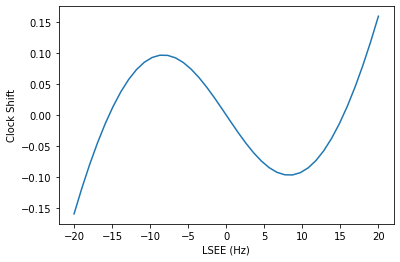

In [149]:
plt.plot(Deltas, shifts)
plt.xlabel("LSEE (Hz)")
plt.ylabel("Clock Shift")
plt.show()